In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.cluster import KMeans
import seaborn as sns
from sklearn.decomposition import PCA

As an initial note, we did both KMeans and PCA to just see which we preferred, we ended up liking both a lot but stuck to PCA.

In [2]:
df = pd.read_csv('exoplanets_cleaned.csv')
df

,pl_name,hostname,default_flag,sy_snum,sy_pnum,discoverymethod,pl_orbper,pl_orbsmax,pl_rade,pl_radj,pl_orbeccen,pl_eqt,st_teff,st_rad,st_mass,habitability_class
0,55 Cnc e,55 Cnc,0,2,5,Radial Velocity,0.736544,0.01544,2.080000,0.185565,0.06100,1958.0,5234.0,0.943,0.905,Not-Habitable Terrestrial
1,AU Mic b,AU Mic,0,1,3,Transit,8.463000,0.06450,4.070000,0.363102,0.00000,593.0,3700.0,0.750,0.500,Not-Habitable Terrestrial
2,AU Mic b,AU Mic,1,1,3,Transit,8.463080,0.06490,3.956770,0.353000,0.00577,600.0,3678.0,0.744,0.510,Not-Habitable Terrestrial
3,AU Mic c,AU Mic,0,1,3,Transit,18.859019,0.11010,3.240000,0.289054,0.00000,454.0,3700.0,0.750,0.500,Not-Habitable Terrestrial
4,AU Mic c,AU Mic,1,1,3,Transit,18.859690,0.11080,2.522021,0.225000,0.00338,459.0,3678.0,0.744,0.510,Not-Habitable Terrestrial
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15158,XO-5 b,XO-5,0,1,1,Transit,4.187757,0.04940,12.206601,1.089000,NaN,1203.0,5370.0,1.065,0.914,Hot Jupiters
15159,XO-6 b,XO-6,1,1,1,Transit,3.765001,0.08150,23.202630,2.070000,0.00000,1577.0,6720.0,1.930,1.470,Hot Jupiters
15160,XO-7 b,XO-7,1,1,1,Transit,2.864142,0.04421,15.389957,1.373000,0.03800,1743.0,6250.0,1.480,1.405,Hot Jupiters
15161,pi Men c,HD 39091,0,1,3,Transit,6.268340,0.06702,2.060000,0.183781,0.00000,1147.0,5870.0,1.100,1.020,Not-Habitable Terrestrial


In [3]:
# Just like in the cleaning_EDA_KNN.ipynb notebook, I Label encoded the habitability_class column
label_encoder = LabelEncoder()
df['habitability_encoded'] = label_encoder.fit_transform(df['habitability_class'])

# Split the data into features and target variable
X = df[['sy_snum', 'pl_rade', 'pl_eqt', 'pl_orbper', 'pl_orbsmax', 'st_teff', 'st_rad', 'st_mass']].copy()
y = df['habitability_encoded']


In [4]:
# Impute missing values with the median of each column
for column in X.columns:
    median = X[column].median()
    X[column] = X[column].fillna(median)

In [6]:
# Check just to be sure that there are no missing values in the dataset
nan_df = X.isnull().sum() * 100 / (X.count() + X.isnull().sum())
nan_df

sy_snum       0.0
pl_rade       0.0
pl_eqt        0.0
pl_orbper     0.0
pl_orbsmax    0.0
st_teff       0.0
st_rad        0.0
st_mass       0.0
dtype: float64

In [7]:
# Apply StandardScaler to the features to ensure they are on the same scale
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

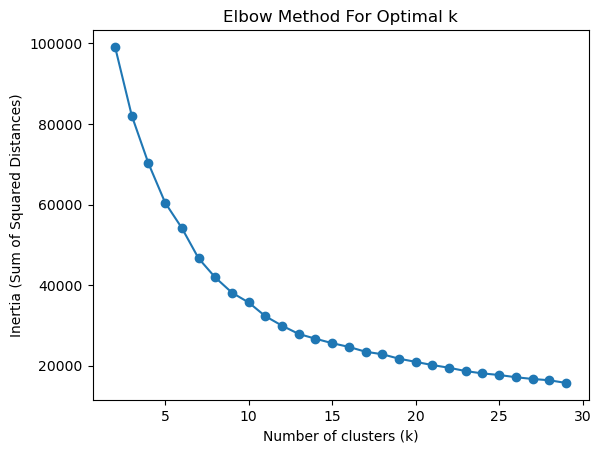

In [8]:
# Generating a KMeans elbow plot to find the optimal number of clusters using similar method as done in class
inertia = []
K = range(2, 30)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# Plot
plt.plot(K, inertia, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia (Sum of Squared Distances)')
plt.title('Elbow Method For Optimal k')
plt.show()


In [9]:
def kmeans_clustering(data, n_clusters, n_init = 500, max_iter = 400, tol = 1e-3):
    kmeans = KMeans(n_clusters = n_clusters, n_init = n_init, max_iter = max_iter, tol = tol)
    kmeans.fit(data)
    data_clustered = data.copy()
    data_clustered['Cluster'] = kmeans.labels_

    return data_clustered

In [11]:
# Convert X_scaled_df back to a DataFrame (had to do this for the function to work)
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

# Apply the function
data_clustered = kmeans_clustering(X_scaled_df, 10)

In [12]:
# Just checking to make sure that the function worked
data_clustered

,sy_snum,pl_rade,pl_eqt,pl_orbper,pl_orbsmax,st_teff,st_rad,st_mass,Cluster
0,3.673043,-0.293906,2.676438,-0.443983,-0.791898,-0.355348,-0.106804,-0.099403,3
1,-0.230128,0.140914,-0.655477,-0.302799,-0.463552,-2.376540,-0.423757,-1.870410,7
2,-0.230128,0.116173,-0.638390,-0.302797,-0.460875,-2.405528,-0.433610,-1.826681,7
3,-0.230128,-0.040443,-0.994771,-0.112834,-0.158363,-2.376540,-0.423757,-1.870410,7
4,-0.230128,-0.197323,-0.982566,-0.112822,-0.153678,-2.405528,-0.433610,-1.826681,7
...,...,...,...,...,...,...,...,...,...
15158,-0.230128,1.918783,0.833511,-0.380920,-0.564612,-0.176154,0.093550,-0.060048,8
15159,-0.230128,4.321443,1.746431,-0.388645,-0.349775,1.602601,1.514093,2.371260,8
15160,-0.230128,2.614354,2.151631,-0.405106,-0.599348,0.983330,0.775082,2.087024,8
15161,-0.230128,-0.298276,0.696817,-0.342902,-0.446686,0.482644,0.151029,0.403475,2


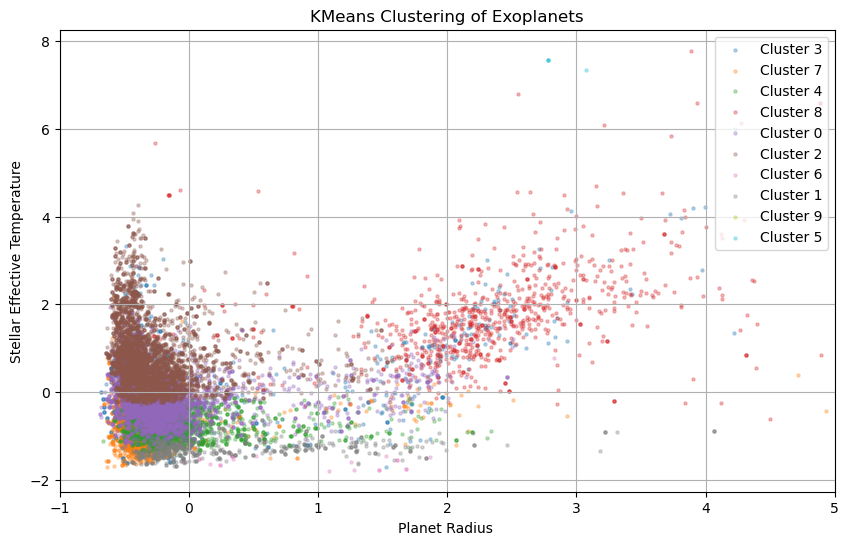

In [13]:
# Let's plot the clusters! Iterating through each cluster and plotting the data points in that cluster
plt.figure(figsize=(10, 6))
for cluster in data_clustered['Cluster'].unique():
    cluster_data = data_clustered[data_clustered['Cluster'] == cluster]
    plt.scatter(cluster_data['pl_rade'], cluster_data['pl_eqt'], label=f'Cluster {cluster}', alpha=0.3, s=5)
plt.legend()
# plt.ylim(-0.2, 0.2)
plt.xlim(-1,5)
plt.xlabel('Planet Radius ')
plt.ylabel('Stellar Effective Temperature')
plt.title('KMeans Clustering of Exoplanets')
plt.legend(loc = 'upper right')
plt.grid()
plt.show()

Clearly a little messy, but can see clusters! Would probably be better to limit the number of data points used in the clustering to better visualize the data. But now onto PCA!

In [14]:
# Applying PCA to reduce the dimensionality of the dataset and see what is going on in the data
pca = PCA(n_components=5)
X_pca = pca.fit_transform(X_scaled_df)
# Converting the PCA result back to a DataFrame for easier use
x_pca_df = pd.DataFrame(X_pca, columns=[f'PC{i+1}' for i in range(X_pca.shape[1])])
x_pca_df

,PC1,PC2,PC3,PC4,PC5
0,1.169090,-1.762136,2.847945,2.373242,0.586519
1,-2.483616,-1.278633,0.696734,-1.197103,0.613000
2,-2.476448,-1.282457,0.684083,-1.181161,0.621605
3,-2.750088,-0.887716,0.595070,-1.075555,0.698743
4,-2.777458,-0.901647,0.507921,-0.975685,0.765223
...,...,...,...,...,...
15158,0.891914,-0.679481,0.975572,-1.468648,-0.717394
15159,4.617998,0.538866,1.658690,-2.367959,-1.546114
15160,3.667074,-0.204351,0.870165,-1.364668,-1.114072
15161,0.857379,-0.500907,-0.510607,0.216250,0.002024


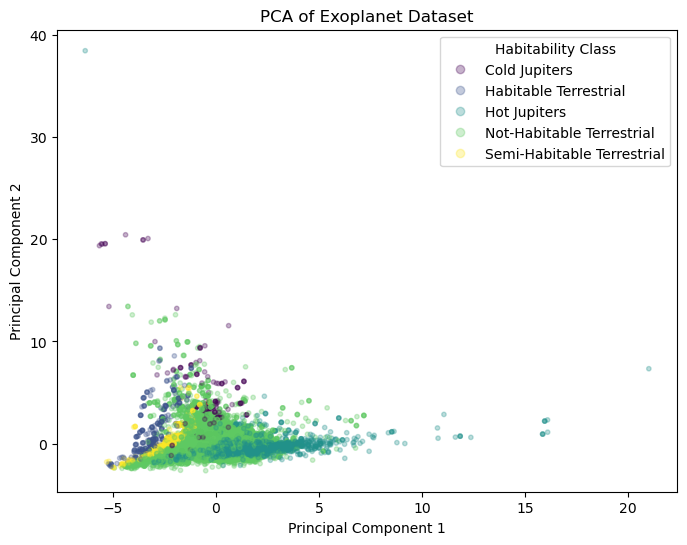

In [17]:
# Plotting the PCA results to see how the data looks in 2D, but first we need to get the labels for the points by using the habitability class
unique_classes = np.unique(y)
class_labels = label_encoder.inverse_transform(unique_classes)  # Decode the class labels

# Time to plot the PCA results! Choosing the first two principal components for the plot
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='viridis', alpha=0.3, s=10)

# Adding a legend to the plot and using handles, _ = scatter.legend_elements() to get the handles for the legend
# This will give us the handles for the legend elements, which we can use to create the legend
handles, _ = scatter.legend_elements()
legend_labels = [f"{label}" for label in class_labels]
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Exoplanet Dataset')
# plt.ylim(-4, 4)
plt.legend(handles, legend_labels, title="Habitability Class", loc='upper right')
plt.show()

Looks nice! What if we did it in 3D... (it will happen after we look at some bar graphs)

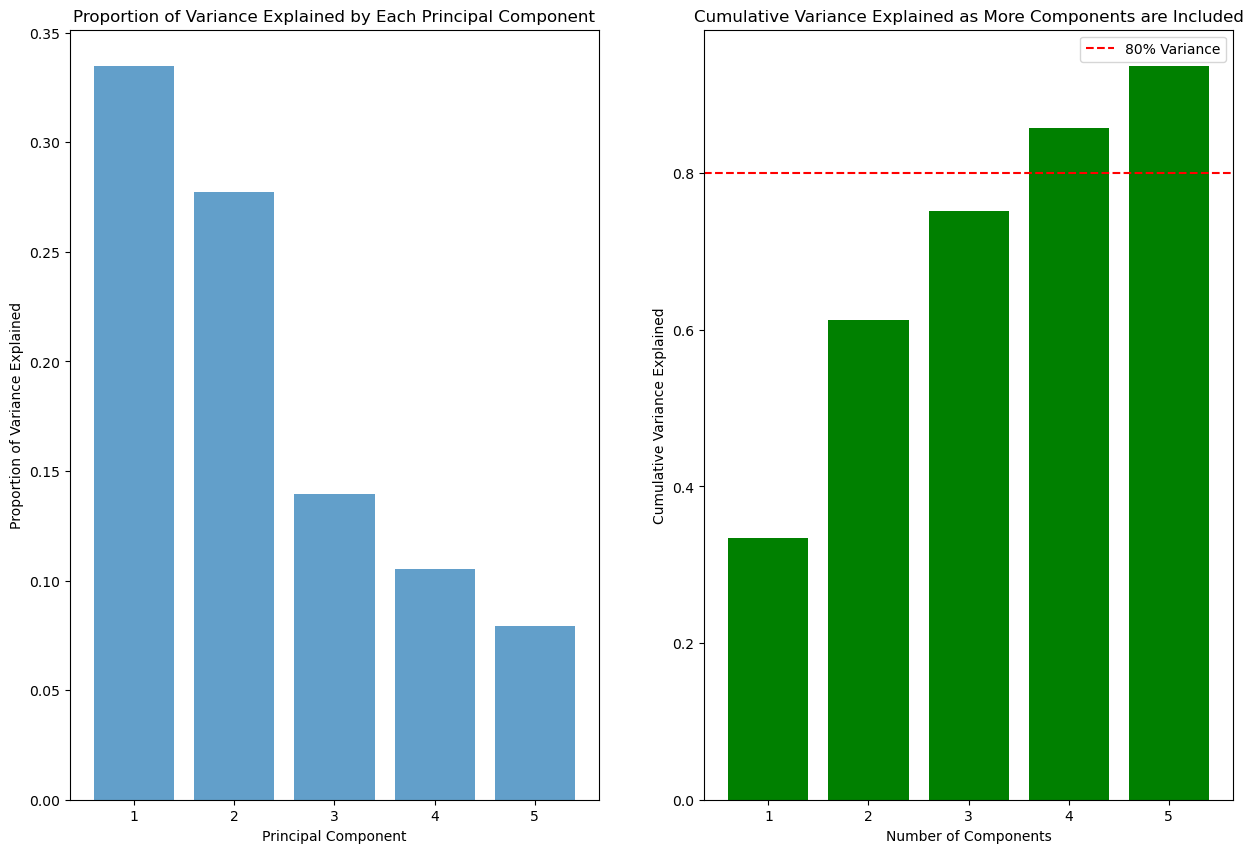

In [18]:
# Now we want ot see how much variance is explained by each principal component, but also the cumulative variance explained as more components are included
proportion_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(proportion_variance)


fig, axes = plt.subplots(1, 2, figsize=(15, 10))

# Plotting the proportion of variance explained by each component like done in class
axes[0].bar(range(1, len(proportion_variance) + 1), proportion_variance, alpha=0.7, label='Individual explained variance')
axes[0].set_title('Proportion of Variance Explained by Each Principal Component')
axes[0].set_xlabel('Principal Component')
axes[0].set_ylabel('Proportion of Variance Explained')

# Plotting the cumulative variance explained as more components are included
axes[1].bar(range(1, len(cumulative_variance) + 1), cumulative_variance, color='green')
axes[1].axhline(y=0.8, color='red', linestyle='--', label='80% Variance')
axes[1].set_title('Cumulative Variance Explained as More Components are Included')
axes[1].set_xlabel('Number of Components')
axes[1].set_ylabel('Cumulative Variance Explained')
axes[1].legend()

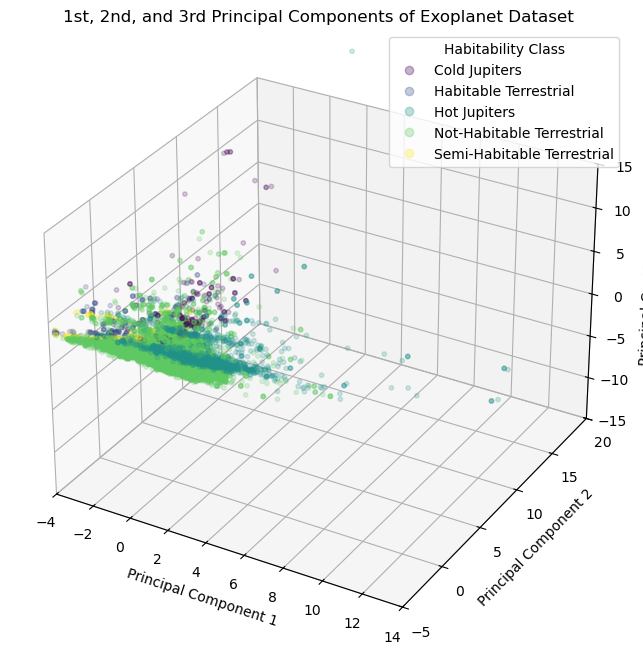

In [ ]:
# 3D time! Using the library provided in class to plot the PCA results in 3D
from mpl_toolkits.mplot3d import Axes3D 

# Peforming the PCA again just to be sure that we have the right data
pca = PCA(n_components=5)
X_pca = pca.fit_transform(X_scaled)

# Plotting the principal components in 3D, which works very similar to the first plot, just we are adding another PCA component
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=y, cmap='viridis', s=10, alpha=0.2)
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
ax.set_xlim(-4, 14)
ax.set_ylim(-5, 20)  
ax.set_zlim(-15, 15)  
plt.title('1st, 2nd, and 3rd Principal Components of Exoplanet Dataset')
# Can easily use the same handles and legend labels as before
plt.legend(handles, legend_labels, title="Habitability Class", loc='upper right')
plt.show()

Looks even better, but what if we could make it spin?

In [ ]:
# Using the same library and method as we did in class, we can animate the 3D plot to spin!
from matplotlib.animation import FuncAnimation

# Creating the animation
def update(frame):
    ax.view_init(elev=10, azim=frame)


ani = FuncAnimation(fig, update, frames=np.arange(0, 360, 2), interval=50)
plt.show()

In [67]:
# Save animation
ani.save('pca_rotation.gif', writer='imagemagick', fps=20)

MovieWriter imagemagick unavailable; using Pillow instead.


Unfortunately, we cannot show it in here, but it is in our presenation!

In [20]:
# Now I want to see what makes up the PCA components, so I will use the PCA loadings to see what features are most important for each component
feature_names = ['sy_snum','pl_rade', 'pl_eqt', 'pl_orbper', 'pl_orbsmax', 'st_teff', 'st_rad', 'st_mass']

# Creating a DataFrame to see the loadings of each feature on each principal component
loadings = pd.DataFrame(pca.components_, columns=feature_names, index=[f'PC{i+1}' for i in range(pca.n_components_)])
loadings

,sy_snum,pl_rade,pl_eqt,pl_orbper,pl_orbsmax,st_teff,st_rad,st_mass
PC1,0.030653,0.242433,0.459043,-0.143743,-0.129262,0.474319,0.420584,0.538819
PC2,-0.026413,0.096537,-0.273899,0.615477,0.650657,0.226124,0.127667,0.212990
PC3,0.759437,0.561671,0.067136,0.082317,0.024051,-0.258572,0.072442,-0.154311
PC4,0.638946,-0.634221,-0.020845,-0.020221,0.010799,0.319026,-0.240156,0.170584
PC5,0.084509,-0.439468,0.057444,0.067349,0.041740,-0.360852,0.800968,-0.135588


And that concludes the KMeans and PCA models! We decided on PCA for our unsupervised model of choice.